<a href="https://colab.research.google.com/github/0o999oo/oe/blob/master/spytorch/SpyTorchTutorial1_XOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Training a spiking neural network with surrogate gradients

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see:
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

## Introduction

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This development begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to these questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial, we use insights and tools from machine learning to build, step-by-step, a spiking neural network. Explicitly, we set out with the goal of building networks that solve (simple) real-world problems. To that end, we focus on classification problems and use supervised learning in conjunction with the aforementioned back-propagation algorithm. To do this, we have to overcome a vanishing gradient problem caused by the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to a discrete-time recurrent neural network (RNN). We will use this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

## Mapping LIF neurons to RNN dynamics

The de-facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$
where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$
for the spike train (ie. the sum of all spikes $C_i^l$ emitted by neuron $i$ in layer $l$). Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of the neuron.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
where we have introduced the synaptic weight matrices $W_{ij}$ (feed-forward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.

To link to RNNs apparent, we will now express the above equations in discrete time. In the interest of brevity we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice, and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike, we start by noting that we can set
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$
with the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
with the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.



These equations can be summarized succinctly as the computational graph of an RNN with a specific connectivity structure.
<img src="figures/snn_graph/snn_graph.png" width="450">
Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs sequentially influence the synaptic currents $I_i^{(1)}$, membrane potentials the $U_i^{(1)}$, and finally the spiking output $S_i^{(1)}$.  Moreover, dynamic quantities have direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity.

The computational graph illustrates a concept which is known as unrolling in time, which emphasizes the duality between a deep neural network and a recurrent neural network, which is nothing more but a deep network in time (with tied weights). Due to this fact, we can train RNNs using the back-propagation of error through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now, let us start by implementing the above dynamics in a three-layer spiking neural network in PyTorch.

## Example network

Let's start with a simple multilayer network model with a single hidden layer, as shown below. For simplicity, we will not use recurrent connections $V$ for now, keeping in mind that they can be added later should the need arise.

<img src="figures/mlp_sketch/mlp_sketch.png">

For the sake of argument, we set the numbers for the input, hidden and output neurons as follows:

In [ ]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

As we have seen above, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms timesteps, and we want to simulate our network for say 200 timesteps.

In [ ]:
time_step = 1e-3
nb_steps  = 200

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

In [ ]:
batch_size = 256

With these basic design choices made, we can now start building the actual network. Here we will be using PyTorch, but you will be able to reproduce these results in most common machine learning libraries.

We start by importing the libraries we need.

In [ ]:
!pip install jupyter==1.0.0 jupyter-client==6.1.6 jupyter-console==6.1.0 jupyter-core==4.6.3
!pip install torch torchvision
!pip install seaborn==0.10.1 h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [ ]:
dtype = torch.float
device = torch.device("cpu")

# Uncomment the line below to run on GPU
# device = torch.device("cuda:0")

### A simple synthetic dataset

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories.

To generate some synthetic data, we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [ ]:
freq = 5 # Hz
prob = freq*time_step
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

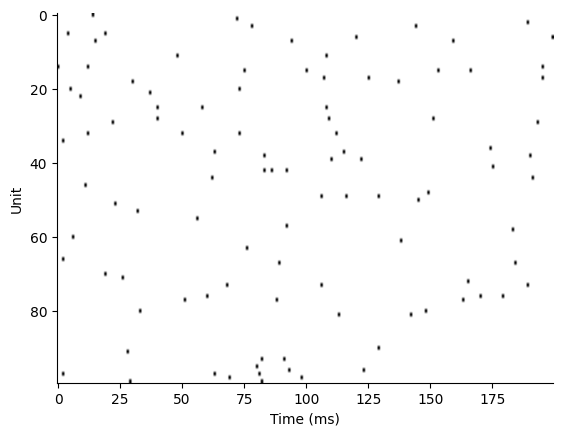

In [ ]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [ ]:
y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)

Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including our $\alpha$ and $\beta$ as described above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Now we set up our weight matrices, which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity, we ignore Dale's law in this tutorial. Thus weights can be either excitatory or inhibitory. This choice is prevalent in artificial neural networks.

In [ ]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


### A spiking neuron model in discrete time

The first thing we need to do to implement our spiking neuron is to multiply all input spikes with the weight matrix. We have to do this for each time step in each input example in the batch. Because we have stored our input spikes in a rank three tensor we can express this operation in a single line:

In [ ]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

These "weighted" input spikes will now feed into our synaptic variable and, ultimately, the membrane potential. To trigger a spike, we need to define moreover a threshold or spike function, which we do in the following. We will later have to alter this definition to train the network, but more about that later.

### The spiking nonlinearity (the naive way)

In discrete-time, as explained earlier, we can formulate our spiking nonlinearity as a Heaviside step function. So let's begin with defining a Heaviside function. One way of implementing it is the following:

In [ ]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

For each trial, we initialize the synaptic currents and membrane potentials at zero.
Next, we need to implement a loop that simulates our neuron models over time.
Moreover, we will record the membrane potentials and output spikes of all trials and all neurons.

In [ ]:
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = []
spk_rec = []

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fn(mthr)
    rst = out.detach() # We do not want to backprop through the reset

    new_syn = alpha*syn +h1[:,t]
    new_mem = (beta*mem +syn)*(1.0-rst)

    mem_rec.append(mem)
    spk_rec.append(out)

    mem = new_mem
    syn = new_syn

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

And that's it. The above loop has now simulated our neurons for '''nb_steps''' and stored their membrane traces and output spikes. Let us take a look at those membrane potentials in which we directly "paste" the spikes for visual inspection. We will directly plot multiple trials at once and define a little helper function for this purpose.

In [ ]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

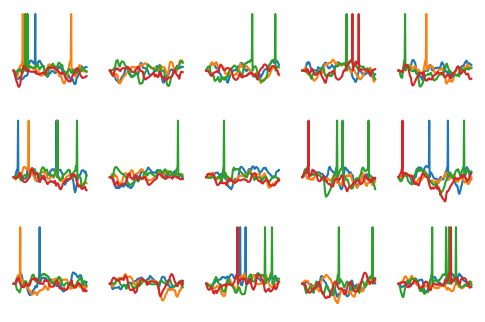

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

As you can see, our random initialization gives us some sporadic spiking. Thus far, we have only an input layer and a spiking layer, which should become our hidden layer. Next, we will have to add a readout layer to our network.

## Adding a readout layer

To use our network as a classifier, we need to have a readout layer on whose output we can define a cost function. There are several possibilities for doing this. For instance, we could count output layer spikes, or we could directly define an objective function on the membrane potential of the output neurons. Here we will follow the latter approach, but keep in mind that there are many other possibilities of defining an output layer and respective cost functions on them.

In the following, we will build the output layer as a population of leaky integrator neurons. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their brethren. Moreover, because we will need this code again, we combine our code from above plus the added readout layer into a single function.

In [ ]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

In [ ]:
out_rec,other_recs = run_snn(x_data)

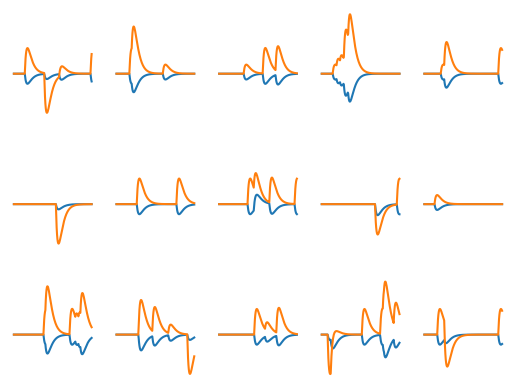

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

By preventing the output neurons from spiking themselves, we can define a relatively smooth objective on their membrane voltages directly. Specifically, we use the maximum voltage over time of each output unit
$$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$
and then use this vector as input for either an argmax to compute the classification accuracy or as we will see below as input for a standard softmax function in conjunction with a negative log-likelihood loss for optimizing the weights in the network.

Let us first compute the classification accuracy of this random network. We will see that this accuracy is somewhere around 50% as it should be since that corresponds to the chance level of our synthetic task.

In [ ]:
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
    output,_ = run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    print("Accuracy %.3f"%acc)

print_classification_accuracy()

Accuracy 0.438


## Supervised learning

So far, we have built the infrastructure to simulate our spiking neural network, but we have worked with purely random network weights thus far.
The vanilla method to adjust network weights to decrease the specified objective is gradient descent.
Machine learning libraries like Tensorflow and PyTorch make implementing gradient descent a breeze.
We first perform gradient descent on the correct gradient and use this as a motivation for introducing surrogate gradients.
Here we go.

### Supervised learning with the true gradient

In [ ]:
params = [w1,w2] # The paramters we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist = []
for e in range(1000):
    # run the network and get output
    output,_ = run_snn(x_data)
    # compute the loss
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    # store loss value
    loss_hist.append(loss_val.item())

loss_hist_true_grad = loss_hist # store for later use

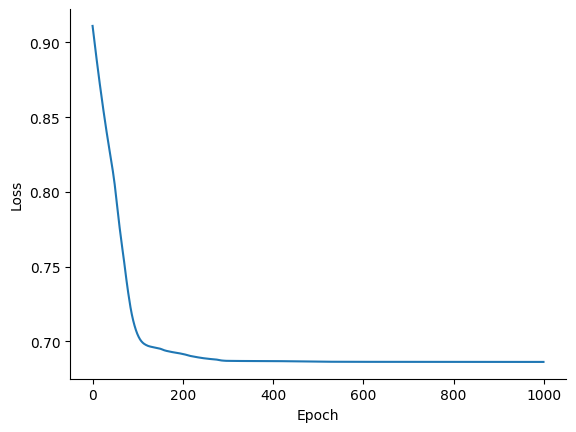

In [ ]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [ ]:
print_classification_accuracy()

Accuracy 0.555


We appreciate that loss decreases over iterations and converges towards a steady state. The classification accuracy, however, does not seem to improve dramatically throughout the optimization. What a shame!

The underlying reason is that the nonlinearity of the hidden units have zero derivatives everywhere except at threshold crossings, where they become infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified. By plotting the hidden layer activations and comparing them with what we have plotted before, we will see that these activations have not changed at all. Thus no learning happens in the hidden layer. The reason why the loss decreased initially during optimization is that the output layer weights could still change and allow for some improvement (even if it was very little).

To improve performance, we need to get the hidden layer units to take part in learning. To achieve this, we will introduce a surrogate gradient in the next section.

In [ ]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

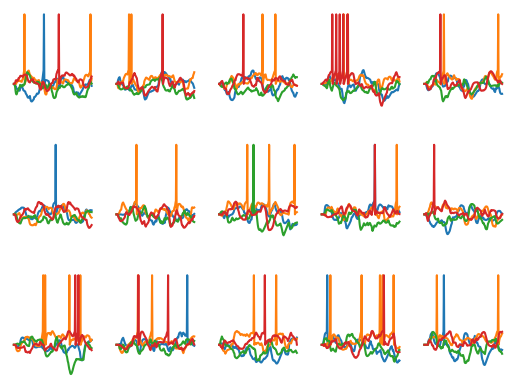

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

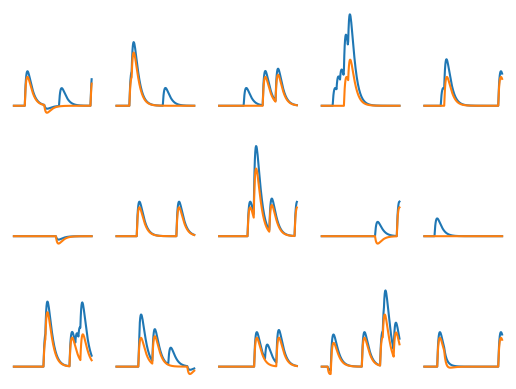

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

### Supervised learning with surrogate gradients

In the last section, we saw that the hidden layer units did not participate.
The underlying reason is that the partial derivative of the step function we used has a vanishing derivative everywhere (except at zero where it becomes infinite).

Most conventional neural networks avoid this problem by choosing a nonlinearity with non-zero partial derivative. For instance, sigmoidal or tanh units were standard during the beginnings of neural networks research. Today, ReLUs are more common. Importantly, all these activation functions have substantial non-zero support, which allows gradients to flow (to a greater or lesser extent).

What do we if we want to stick to our binary nonlinearity? There have been several approaches to tackle this problem. Here we use one such strategy which has been applied successfully to spiking neural networks: We use a surrogate gradient approach.

The idea behind a surrogate gradient is dead simple. Instead of changing the nonlinearity itself, we only change the gradient. Thus we use a different "surrogate" gradient to optimize parameters that would otherwise have a vanishing gradient.

<img src="figures/surrgrad/surrgrad.png" width="450">
Specifically, we use the partial derivative of a function which to some extent approximates the stepfunction $\Theta(x)$.
In what follows, chiefly, we will use (up to rescaling) the partial derivative of a fast sigmoid function $\sigma(x)$.
While $\Theta$ is invariant to multiplicative rescaling, $\sigma$ isn't. Thus we have to introduce a scale parameter.

In [ ]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [ ]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


In [ ]:
params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

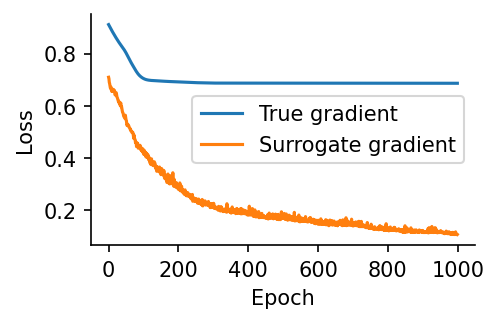

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [ ]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

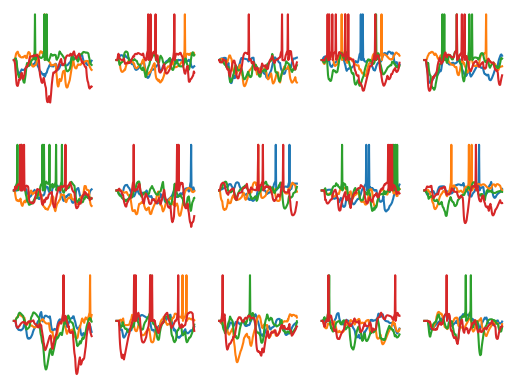

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

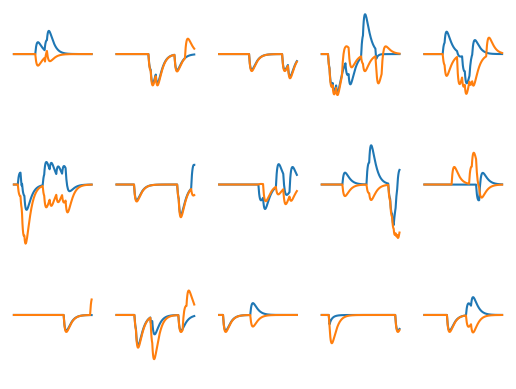

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

In [ ]:
output,_ = run_snn(x_data)
m,_=torch.max(output,1)

# Compute training accuracy
_,am=torch.max(m,1)
acc = np.mean((y_data==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.875000


# 試作コードその１

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")

# 3種類のfreqを設定
freq_values = [3, 10, 50]
time_step = 1e-3
nb_inputs = 100
nb_hidden = 4
nb_outputs = 2
nb_steps = 200
batch_size = 256

# 入力データと教師ラベルを生成するためのリスト
x_data_list = []
y_data_list = []

for freq in freq_values:
    prob = freq * time_step
    mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
    x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
    x_data[mask < prob] = 1.0
    x_data_list.append(x_data)

    # freqが3のときは0、それ以外は1をラベルとする
    label = 0 if freq == 3 else 1
    y_data = torch.tensor([label] * batch_size, device=device)
    y_data_list.append(y_data)

# 各freqの入力データとラベルを結合して1つの大きなバッチにする
x_data_combined = torch.cat(x_data_list, dim=0)
y_data_combined = torch.cat(y_data_list, dim=0)

# データ確認のためのプロット
data_id = 0
plt.imshow(x_data_combined[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

print("Combined input data shape:", x_data_combined.shape)
print("Combined labels shape:", y_data_combined.shape)

tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

h1 = torch.einsum("abc,cd->abd", (x_data, w1))

def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = []
spk_rec = []

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fn(mthr)
    rst = out.detach() # We do not want to backprop through the reset

    new_syn = alpha*syn +h1[:,t]
    new_mem = (beta*mem +syn)*(1.0-rst)

    mem_rec.append(mem)
    spk_rec.append(out)

    mem = new_mem
    syn = new_syn

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

out_rec,other_recs = run_snn(x_data)

fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

def print_classification_accuracy():
    output,_ = run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    print("Accuracy %.3f"%acc)

print_classification_accuracy()

params = [w1,w2] # The paramters we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist = []
for e in range(1000):
    # run the network and get output
    output,_ = run_snn(x_data)
    # compute the loss
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    # store loss value
    loss_hist.append(loss_val.item())

loss_hist_true_grad = loss_hist # store for later use

plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

print_classification_accuracy()

output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

fig=plt.figure(dpi=100)
plot_voltage_traces(output)

class SurrGradSpike(torch.autograd.Function):

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

fig=plt.figure(dpi=100)
plot_voltage_traces(output)

output,_ = run_snn(x_data)
m,_=torch.max(output,1)

# Compute training accuracy
_,am=torch.max(m,1)
acc = np.mean((y_data==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

# 試作コードその２

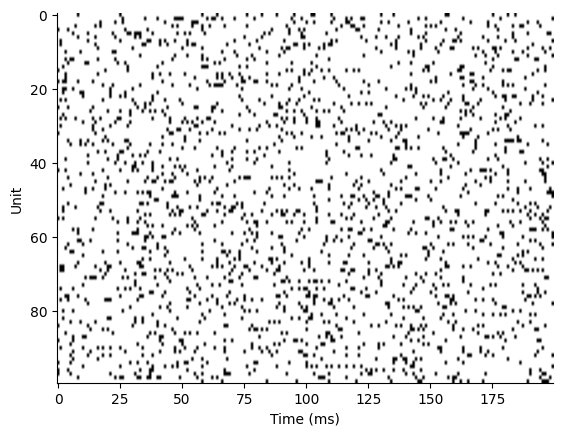

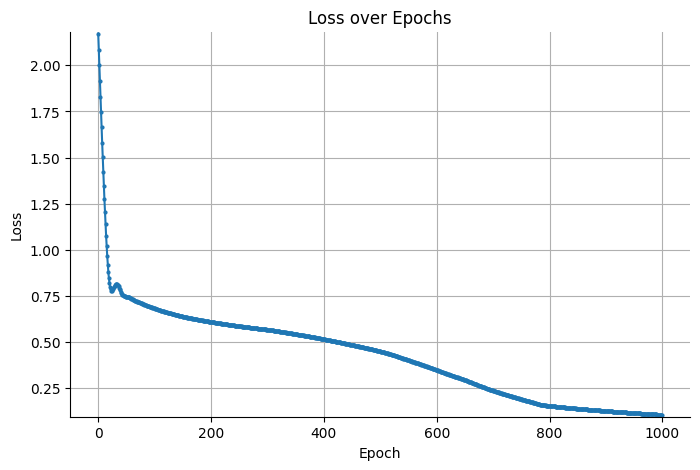

Accuracy 0.979
Test Accuracy: 0.971
Frequency 100 Hz Accuracy: 0.980
Frequency 500 Hz Accuracy: 0.934
Frequency 1000 Hz Accuracy: 1.000


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")

# freq の設定
freq_values = [100, 500, 1000]
batch_size = 256  # バッチサイズをここで設定

# 入力データ生成
time_step = 1e-3
nb_inputs = 100
nb_hidden = 4
nb_outputs = 2
nb_steps = 200

# 各周波数に対応するラベルと入力データを生成
x_data = []
y_data = []

for f in freq_values:
    prob = f * time_step
    mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
    x_data_freq = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
    x_data_freq[mask < prob] = 1.0
    label = 0 if f == 10 or f == 1000 else 1  # freq=3ならラベル0、それ以外は1
    y_data_freq = torch.tensor([label] * batch_size, device=device)

    x_data.append(x_data_freq)
    y_data.append(y_data_freq)

# 入力データとラベルを結合してバッチにまとめる
x_data = torch.cat(x_data, dim=0)  # (3 * batch_size, nb_steps, nb_inputs)
y_data = torch.cat(y_data, dim=0)  # (3 * batch_size, )

# 入力データの一部を可視化
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

# モデルの初期化
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step / tau_syn))
beta = float(np.exp(-time_step / tau_mem))

weight_scale = 7 * (1.0 - beta)  # 初期スパイクを作るためのスケール設定

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(nb_hidden))

# SNNの前方計算関数を定義
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((inputs.size(0), nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((inputs.size(0), nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    def spike_fn(x):
        out = torch.zeros_like(x)
        out[x > 0] = 1.0
        return out

    # 隠れ層の活動を計算
    for t in range(nb_steps):
        mthr = mem - 1.0
        out = spike_fn(mthr)
        rst = out.detach()  # リセット時にバックプロパゲーションを防ぐ

        new_syn = alpha * syn + h1[:, t]
        new_mem = (beta * mem + syn) * (1.0 - rst)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    # 出力層の計算
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((inputs.size(0), nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((inputs.size(0), nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha * flt + h2[:, t]
        new_out = beta * out + flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec, dim=1)
    return out_rec, [mem_rec, spk_rec]

# 学習関数
def train_snn():
    params = [w1, w2]
    optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))  # Adamオプティマイザー

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    for e in range(1000):
        output, _ = run_snn(x_data)
        m, _ = torch.max(output, 1)
        log_p_y = log_softmax_fn(m)
        loss_val = loss_fn(log_p_y, y_data)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        loss_hist.append(loss_val.item())

    return loss_hist

loss_hist = train_snn()

# 損失の推移をプロット
plt.figure(figsize=(8, 5))
plt.plot(loss_hist, marker='o', markersize=2, linestyle='-')
plt.ylim(min(loss_hist) - 0.01, max(loss_hist) + 0.01)  # y軸を自動調整
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
sns.despine()
plt.show()

# 最終的な精度の確認
def print_classification_accuracy():
    output, _ = run_snn(x_data)
    m, _ = torch.max(output, 1)
    _, am = torch.max(m, 1)
    acc = np.mean((y_data == am).detach().cpu().numpy())  # ラベルと比較
    print("Accuracy %.3f" % acc)

print_classification_accuracy()


# 推論用データの生成
def generate_test_data():
    test_x_data = []
    test_y_data = []
    for f in freq_values:
        prob = f * time_step
        mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
        x_data_freq = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
        x_data_freq[mask < prob] = 1.0
        label = 0 if f == 10 or f == 1000 else 1  # freq=3ならラベル0、それ以外は1
        y_data_freq = torch.tensor([label] * batch_size, device=device)

        test_x_data.append(x_data_freq)
        test_y_data.append(y_data_freq)

    # テストデータを結合してバッチにまとめる
    test_x_data = torch.cat(test_x_data, dim=0)  # (3 * batch_size, nb_steps, nb_inputs)
    test_y_data = torch.cat(test_y_data, dim=0)  # (3 * batch_size, )
    return test_x_data, test_y_data

# 推論の実行と精度の評価
def evaluate_snn():
    test_x_data, test_y_data = generate_test_data()
    output, _ = run_snn(test_x_data)
    m, _ = torch.max(output, 1)
    _, predicted_labels = torch.max(m, 1)

    # 正解ラベルと予測ラベルを比較して精度を計算
    accuracy = np.mean((test_y_data == predicted_labels).detach().cpu().numpy())
    print("Test Accuracy: %.3f" % accuracy)

    # 各周波数ごとの分類結果を表示
    for i, f in enumerate(freq_values):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        acc_per_freq = np.mean((test_y_data[start_idx:end_idx] == predicted_labels[start_idx:end_idx]).detach().cpu().numpy())
        print(f"Frequency {f} Hz Accuracy: {acc_per_freq:.3f}")

# 推論の実行
evaluate_snn()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.